### Stan
Using the statistical modelling software stan (here its Python interface Pystan) to use the PMCMC algorithm to solve the SARS-CoV-2 model. 

In [1]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('utils')
from utils.model import *

sns.set()  # Nice plot aesthetic
np.random.seed(101)

#### Define the model in stan
Structure:

1. functions:  external functions needed (here: differential equation)
2. data:                    all the data including observations, time and known parameters
3. tranformed data:         if the data still needs to be transformed
4. parameters:              the parameters (which need to be estimated)
5. transformed parameters:  potential transformation of the parameters (here: solve the differential equation)
6. model:                   define the probability distributions that define your model
7. generated quantities:    in case any other parameters might be needed to be computed

In [ ]:
# older model:
model = """
data {

  int<lower=0> N;  // num people
  int<lower=0> T;  // num instances
  int<lower=0> Z_0 // initial number of cases
  int<lower=0, upper=N> X[T];// observations
  
  
  int<lower=0> K;   // dimension of Hidden state
  
  // unsupervised:
  //int<lower=0, upper=N> Z[T];
}
parameters {
  real<lower=0, upper = 1> p_inf;
  real<lower=0, upper = 1> p_obs;
}

transformed parameters {
  vector[K] logalpha[T];
  
  { // Forward algorithm log p(z_t = j | y_{1:t})
    real accumulator[K];
    logalpha[1] = log(pi1) + normal_lpdf(y[1] | mu, sigma);
    
    for (t in 2:T) {
      for (j in 1:K) { // j = current (t)
        for (i in 1:K) { // i = previous (t-1)
          // Murphy (2012) p. 609 eq. 17.48
          // belief state + transition prob + local evidence at t
          accumulator[i] = logalpha[t-1, i] + log(A[i, j]) + normal_lpdf(y[t] | mu[j], sigma[j]);
        }
        logalpha[t, j] = log_sum_exp(accumulator);
      }
    }
  } // Forward
}
model {
  // priors


  // forward algorithm
  {
  real acc[K];
  real gamma[N, K];                                  //log marginal probability of the inputs
  for (k in 1:K)
    gamma[1, k] = Z_0;
  for (t in 2:N) {
    for (k in 1:K) {
      for (j in 1:K)
        acc[j] = gamma[t-1, j] + log(theta[j, k]) + normal_lpdf(y[t] | mu[k], 1);
      gamma[t, k] = log_sum_exp(acc);
    }
  }
  target += log_sum_exp(gamma[N]);
  }


  for (t in 2:T)
    Z[t] ~ binomial(N-Z[t-1], p_inf); //+  Z[t - 1]
  for (t in 1:T)
    X[t] ~ neg_binomial(Z[t], p_obs);    // p_obs = probability of observation
}
"""

In [33]:
model = """functions {
  real[] SEIR(
      real t,             // time
      real[] Z,           // system state {susceptible, exposed, infected, recovered}
      real[] theta,       // parameters (t_inc, t_inf, r_t, mu, t_rec, rho = 1, kappa_0, kappa)
      real[] X_r,         // --------probably not needed
      int[] X_i) {        // --------probably not needed
  
          real dZ_dt[4];
          
          real t_inc   = theta[1];
          real t_inf   = theta[2];
          real r_t     = theta[3];
          real rho     = theta[4];
          real kappa_0 = theta[5];
          real kappa   = theta[6];
         
          dZ_dt[1] = - rho * (r_t/t_inf) * Z[1] * Z[2]  - kappa_0 * Z[1] ;     
          dZ_dt[2] = (rho * (r_t/t_inf) * Z[1] * Z[2])    -     ((1/t_inc) * Z[2]) - kappa_0 * Z[3] - kappa * Z[3]  ;    
          dZ_dt[3] = ((1/t_inc) * Z[2]) -   (1/t_inf) * Z[3];
          dZ_dt[4] = (1/t_inf) * Z[3];
          
          return dZ_dt;
      }
  }
  
  data {
     int<lower = 1> n_obs;       // number of days observed
     int<lower = 1> n_theta;     // number of model parameters (=8)
     int<lower = 1> n_difeq;     // number of differential equations (=4)
     real<lower = 1> n_pop;       // population 
     int X[n_obs];           // data, total number of infected individuals each day
     real t0;                // initial time point (zero)
     real ts[n_obs];         // time points that were observed
     
     // known parameters:
     real kappa_0;
     real kappa;
     real p_obs;
  }
  
  transformed data {
    real X_r[0];
    int X_i[0];
  }
  
  parameters {
    // theta:
    real<lower=0.1, upper= 50> t_inc;
    real<lower=0.1, upper= 50> t_inf;
    real<lower=0, upper= 20> r_t;
    real<lower=0, upper=1> rho;
    
    real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
    
    //real<lower = 0, upper = 1> p_obs;
    //real<lower = 0, upper = 1> p_inf;
  }
  
  transformed parameters{
    real Z_hat[n_obs, n_difeq];       // solution from the ODE solver
    //int Z_i[n_obs, n_difeq];          // integer values
    real Z_init[n_difeq];             // initial conditions for both fractions of S and I
    
    real theta[n_theta];
    theta[1] = t_inc;
    theta[2] = t_inf;
    theta[3] = r_t;
    theta[4] = rho;
    theta[5] = kappa_0;
    theta[6] = kappa;

  
    Z_init[1] = S0;
    Z_init[2] = 1 - S0;
    Z_init[3] = 0;
    Z_init[4] = 0;
    
    Z_hat = integrate_ode_rk45(SEIR, Z_init, t0, ts, theta, X_r, X_i);
    
  }
  
  model {
  
    //priors
    //theta[1] ~ lognormal(0,1);
    //theta[2] ~ gamma(0.004,0.02);  //Assume mean infectious period = 5 days 
    t_inc ~ normal(5, 0.5);
    t_inf ~ normal(9, 0.5);
    r_t   ~ normal(2.5, 1);
    rho   ~ beta(0.5, 0.5);

    S0 ~ beta(0.5, 0.5);
  
    
    //likelihood
    X ~ neg_binomial(to_vector(Z_hat[,2])*n_pop, p_obs);
    
  }
  
  //generated quantities {
  //real R_0;      // Basic reproduction number
  //R_0 = theta[1]/theta[2];
  //}
  """

In [34]:
# Compile the model
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_701404cc2f81ea94fb8a54d94256507f NOW.


### The data
For now sample the data from an idealistic model:

2000


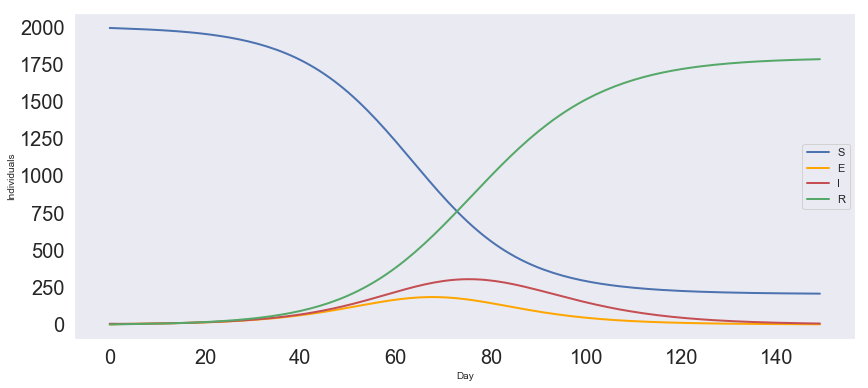

In [35]:
# data generation parameters:
n_obs = 150
init_inf  = 5
t_inc     = 5
t_inf     = 9
r_t       = 2.5
rho       = 1.0

kappa_0   = 0.0
kappa     = 0.0

n_pop     = 2000

seir = SEIRModel(n_obs, n_pop, init_inf, t_inc, t_inf, r_t, rho, kappa_0, kappa)

s, e, i, r = seir.run()

# concatenate vectors into matrix:
Z = np.vstack((s, e,i, r)) * n_pop

seir.visualization(n_pop)

# generate obserations:
p_obs     = 0.7
def sample_X(n_obs , I , p_obs):
    X = np.zeros(n_obs, dtype=int)
    for t in range(0, n_obs):
        X[t] =  np.random.negative_binomial(I[t], p_obs, size=1) 
    return X;

X         = sample_X(n_obs , Z[2,:] , p_obs)

In [36]:
# see if observations make sense
#plt.plot(X,c='r')
#plt.plot(Z[2,:])

In [37]:
# unknown:
init_inf  = 5
t_inc     = 5
t_inf     = 9
r_t       = 2.5
rho       = 1.0


# known:
p_obs     = 0.7
kappa_0   = 0.0
kappa     = 0.0


# Put data in a dictionary
n_obs     = 150
n_theta   = 6
n_difeq   = 4
n_pop     = 2000
ts = np.arange(1,n_obs+1);

data = {'n_obs': n_obs, 'n_theta': n_theta, 'n_difeq': n_difeq, 'n_pop':n_pop, 'X': X, 't0': 0, 'ts': ts, 'kappa_0':kappa_0 ,'kappa':kappa, 'p_obs':0.7}


### Train the model with the data

In [38]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101,verbose=True)

In [39]:
#learned statistics:
print(fit)

Inference for Stan model: anon_model_701404cc2f81ea94fb8a54d94256507f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean      sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
t_inc          4.76  2.6e-3    0.06    4.63   4.71   4.76    4.8   4.89    612    1.0
t_inf          8.99    0.02    0.47    8.03   8.68    9.0   9.31   9.89    506   1.01
r_t            2.82    0.06     0.3    2.41   2.65   2.77   2.92   3.68     24   1.09
rho            0.94    0.02    0.07    0.71   0.92   0.96   0.99    1.0     12   1.13
S0              1.0  1.5e-6  3.8e-5     1.0    1.0    1.0    1.0    1.0    684    1.0
Z_hat[1,1]      1.0  1.8e-6  4.8e-5     1.0    1.0    1.0    1.0    1.0    691    1.0
Z_hat[2,1]      1.0  2.3e-6  5.9e-5     1.0    1.0    1.0    1.0    1.0    696    1.0
Z_hat[3,1]      1.0  2.7e-6  7.1e-5     1.0    1.0    1.0    1.0    1.0    699    1.0
Z_hat[4,1]      1.0  3.2e-6  8.4e-5    

In [41]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Extracting traces
#p_obs_hat  = fit['p_obs']
t_inc_hat  = fit['t_inc']
t_inf_hat  = fit['t_inf']
r_t_hat    = fit['r_t']
rho_hat    = fit['rho']
lp         = fit['lp__']

In [42]:
# extract found Z mean values:
Z_hat = np.zeros((n_difeq,n_obs), dtype = int)
for i in range(0,4):
    for t in range(0,n_obs):
        index = 'Z_hat['+str(t+1)+','+str(i+1)+']'
        Z_hat[i,t]= int(df.loc[index,'mean']*n_pop)

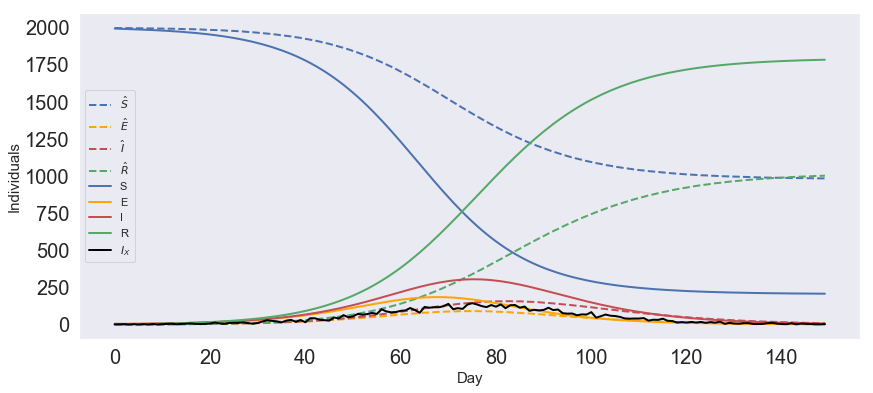

In [43]:
# Visualizing the process.
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(Z_hat[0,:], c='b', lw=2, label='$\hat{S}$', linestyle = '--')
ax.plot(Z_hat[1,:], c='orange', lw=2, label='$\hat{E}$', linestyle = '--')
ax.plot(Z_hat[2,:], c='r', lw=2, label='$\hat{I}$', linestyle = '--')
ax.plot(Z_hat[3,:], c='g', lw=2, label='$\hat{R}$', linestyle = '--')

ax.plot(Z[0,:], c='b', lw=2, label='S')
ax.plot(Z[1,:], c='orange', lw=2, label='E')
ax.plot(Z[2,:], c='r', lw=2, label='I')
ax.plot(Z[3,:], c='g', lw=2, label='R')

ax.plot(X, c='black', lw=2, label='$I_X$')

ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('Individuals', fontsize=15)
ax.grid()

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.show()

In [ ]:
df

In [44]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

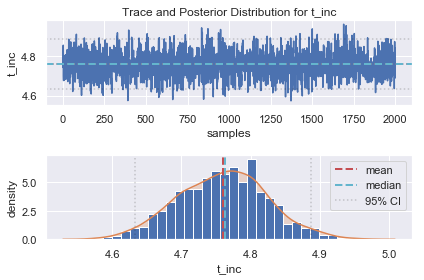

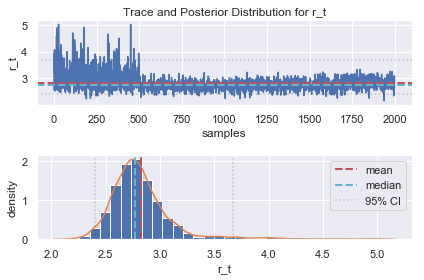

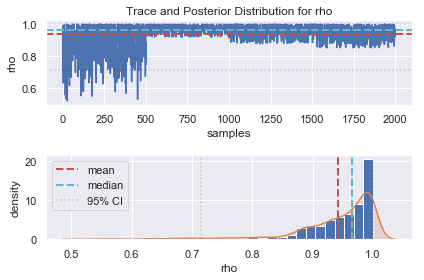

In [46]:
#plt.figure();
#plot_trace(p_obs_hat, param_name='p_obs')
plt.figure();
plot_trace(t_inc_hat, param_name='t_inc')
plt.figure();
plot_trace(r_t_hat, param_name='r_t')
plt.figure();
plot_trace(rho_hat, param_name='rho')


### Very simple older model:

In [ ]:
def sample_Z( T, p_inf, N, Z_0= 1):
    Z = np.zeros(T,dtype=int)
    Z[0] = Z_0;
    for t in range(1, T):
        Z[t] =  Z[t - 1]+np.random.binomial(N-Z[t-1], p_inf, 1) # one try    
    return Z;

def sample_X(T,Z, p_obs):
    X = np.zeros(T,dtype=int)
    for t in range(0, T):
        X[t] =  Z[t] +np.random.negative_binomial(Z[t], p_obs, size=1) 
    return X;

In [ ]:
# Parameters to be inferred
p_inf   = 0.001
p_obs   = 0.7

# sample from a data generator
Z = sample_Z( T, p_inf, N, Z_0= 10)
X = sample_X( T, Z, p_obs)
print(Z)
print(X)

In [ ]:
plt.plot(Z, color ="red")
plt.plot(X)

In [ ]:
# Put our data in a dictionary
data = {'N': N, 'T': T, 'X': X, 'Z':Z}

In [ ]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

In [ ]:
print(fit)

In [ ]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['p_inf'], df['mean']['p_obs']

# Extracting traces
p_inf_f = fit['p_inf']
p_obs_f = fit['p_obs']
lp = fit['lp__']

In [ ]:
plot_trace(p_obs_f, param_name='parameter')